In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import typing

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from collections import defaultdict

/usr/local/anaconda3/envs/pitch-sequencing/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [3]:
raw_df = pd.read_csv('../../data/raw_data_curmap.csv')

In [5]:
raw_df.head(20)

,game_date,pitch_number,batter,pitcher,balls,strikes,type,pitch_type,events,at_bat_number,player_name
0,2017-04-02,1,543305,643493,0,0,S,CB,NaN,76,"Pruitt, Austin"
1,2017-04-02,2,543305,643493,0,1,B,CH,NaN,76,"Pruitt, Austin"
2,2017-04-02,3,543305,643493,1,1,B,SI,NaN,76,"Pruitt, Austin"
3,2017-04-02,4,543305,643493,2,1,X,SI,single,76,"Pruitt, Austin"
4,2017-04-02,1,474892,517008,0,0,S,FC,NaN,77,"Colomé, Alex"
5,2017-04-02,2,474892,517008,0,1,B,FC,NaN,77,"Colomé, Alex"
6,2017-04-02,3,474892,517008,1,1,S,FC,NaN,77,"Colomé, Alex"
7,2017-04-02,4,474892,517008,1,2,B,FC,NaN,77,"Colomé, Alex"
8,2017-04-02,5,474892,517008,2,2,X,FC,sac_fly,77,"Colomé, Alex"
9,2017-04-02,1,596142,517008,0,0,S,FC,NaN,78,"Colomé, Alex"


In [7]:
raw_df['combined_count'] = raw_df['balls'].astype(str) + "-" + raw_df['strikes'].astype(str)

In [8]:
raw_df.head(10)

,game_date,pitch_number,batter,pitcher,balls,strikes,type,pitch_type,events,at_bat_number,player_name,combined_count
0,2017-04-02,1,543305,643493,0,0,S,CB,NaN,76,"Pruitt, Austin",0-0
1,2017-04-02,2,543305,643493,0,1,B,CH,NaN,76,"Pruitt, Austin",0-1
2,2017-04-02,3,543305,643493,1,1,B,SI,NaN,76,"Pruitt, Austin",1-1
3,2017-04-02,4,543305,643493,2,1,X,SI,single,76,"Pruitt, Austin",2-1
4,2017-04-02,1,474892,517008,0,0,S,FC,NaN,77,"Colomé, Alex",0-0
5,2017-04-02,2,474892,517008,0,1,B,FC,NaN,77,"Colomé, Alex",0-1
6,2017-04-02,3,474892,517008,1,1,S,FC,NaN,77,"Colomé, Alex",1-1
7,2017-04-02,4,474892,517008,1,2,B,FC,NaN,77,"Colomé, Alex",1-2
8,2017-04-02,5,474892,517008,2,2,X,FC,sac_fly,77,"Colomé, Alex",2-2
9,2017-04-02,1,596142,517008,0,0,S,FC,NaN,78,"Colomé, Alex",0-0


In [11]:
count_state_df = raw_df.groupby(['combined_count', 'pitch_type']).size().reset_index(name='frequency')

In [15]:
count_state_df

,combined_count,pitch_type,frequency
0,0-0,CB,147362
1,0-0,CH,86847
2,0-0,FC,79890
3,0-0,FF,438067
4,0-0,FS,11085
...,...,...,...
118,4-1,SL,1
119,4-2,CH,2
120,4-2,FF,11
121,4-2,SI,6


In [23]:
# Remove values that I'm not sure why are there
count_state_df = count_state_df[count_state_df['combined_count'] != '4-2']
count_state_df = count_state_df[count_state_df['combined_count'] != '4-1']
count_state_df = count_state_df[count_state_df['combined_count'] != '1-3']

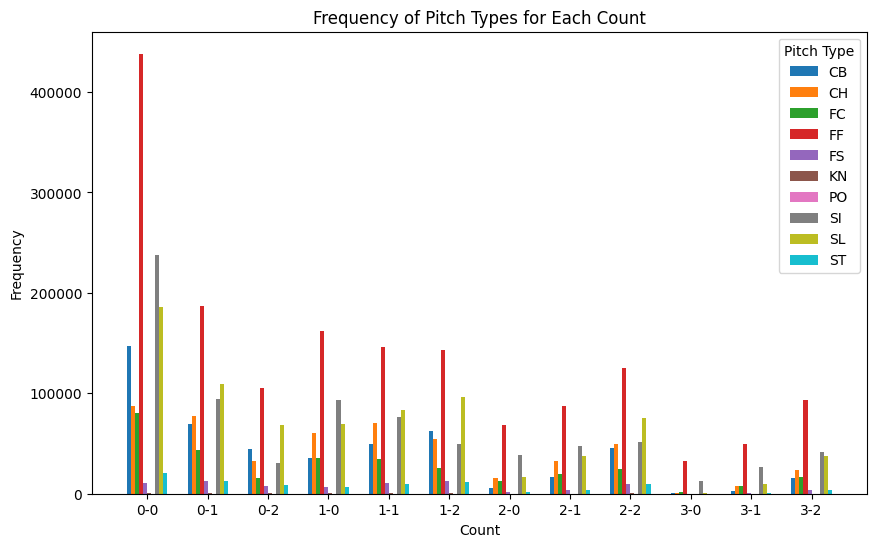

In [24]:
import matplotlib.pyplot as plt

# Create a pivot table for easier plotting
pivot_df = count_state_df.pivot(index='combined_count', columns='pitch_type', values='frequency').fillna(0)

# Get unique pitch types and counts for plotting
pitch_types = pivot_df.columns.tolist()
counts = pivot_df.index.tolist()

# Number of pitch types
n_types = len(pitch_types)

# Position of bars on x-axis
ind = np.arange(len(counts))*1.5

# Width of each bar
width = 0.1

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

for i, pitch_type in enumerate(pitch_types):
    ax.bar(ind + i * width, pivot_df[pitch_type], width, label=pitch_type)

# Add some text for labels, title and axes ticks
ax.set_xlabel('Count')
ax.set_ylabel('Frequency')
ax.set_title('Frequency of Pitch Types for Each Count')
ax.set_xticks(ind + width * (n_types - 1) / 2)
ax.set_xticklabels(counts)
ax.legend(title='Pitch Type')

plt.show()

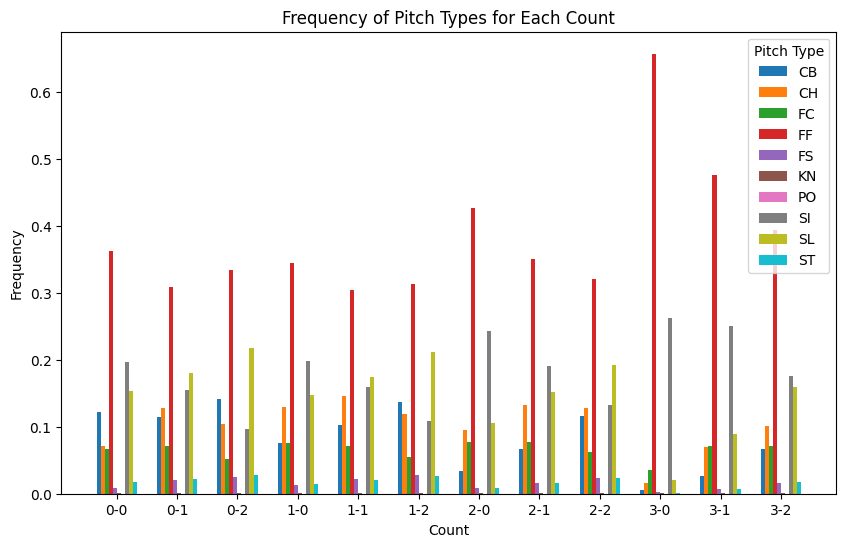

In [25]:
normalized_pivot_df = pivot_df.div(pivot_df.sum(axis=1), axis=0)
# Get unique pitch types and counts for plotting
pitch_types = normalized_pivot_df.columns.tolist()
counts = normalized_pivot_df.index.tolist()

# Number of pitch types
n_types = len(pitch_types)

# Position of bars on x-axis
ind = np.arange(len(counts))*1.5

# Width of each bar
width = 0.1

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

for i, pitch_type in enumerate(pitch_types):
    ax.bar(ind + i * width, normalized_pivot_df[pitch_type], width, label=pitch_type)

# Add some text for labels, title and axes ticks
ax.set_xlabel('Count')
ax.set_ylabel('Frequency')
ax.set_title('Frequency of Pitch Types for Each Count')
ax.set_xticks(ind + width * (n_types - 1) / 2)
ax.set_xticklabels(counts)
ax.legend(title='Pitch Type')